In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse
import time
import tkinter as tk
from tkinter import messagebox
import math

# our functions
import predict_Beta_I
import choice_start_day

import warnings
warnings.filterwarnings(action='ignore')

# для учета обновлений при изменении файлов
%load_ext autoreload
%autoreload 2

# Основная программа

In [7]:
def plot_one(ax, 
             predicted_days, seed_df, predicted_I, beggining_beta, predicted_beta,
             seed_number, execution_time):
    '''
    Построение графика для seed.
    
    Параметры:

    - ax -- область для графика
    - predicted_days -- дни предсказания
    - seed_df -- DataFrame of seed, созданный регулярной сетью
    - predicted_I -- предсказанные траектория компартмента Infected
    - beggining_beta -- предсказанные начальные значения Beta
    - predicted_beta -- предсказанные значения Beta
    - seed_number -- номер seed        
    - execution_time - время предсказания Beta   
    '''

    # при сдвиге прогнозов иногда здесь нан
    predicted_I[np.isnan(predicted_I)] = 0.0
    # if predicted_beta not array
    predicted_beta = np.array(predicted_beta)
    beggining_beta = np.array(beggining_beta)
    
    predicted_beta[np.isnan(predicted_beta)] = 0.0
    beggining_beta[np.isnan(beggining_beta)] = 0.0

    # Находим максимум и его индекс
    predicted_peak_I = max(predicted_I[0])
    predicted_peak_day = predicted_days[0] + np.argmax(predicted_I[0])
    actual_I = seed_df.iloc[:]['I'].values 
    actual_peak_I = max(actual_I)
    actual_peak_day = np.argmax(actual_I)+1

    peak = [actual_peak_I, predicted_peak_I,actual_peak_day,predicted_peak_day] 

    # подсчет RMSE для значений Infected и Beta
    actual_I = seed_df.iloc[predicted_days[0]:]['I'].values 
    rmse_I = rmse(actual_I, predicted_I[0])
    actual_Beta = seed_df.iloc[predicted_days[0]:]['Beta'].values 
    rmse_Beta = rmse(actual_Beta, predicted_beta)   

    # отображение границы перехода
    ax.axvline(predicted_days[0], color='red',ls=':')

    # отображение реальных и предсказанных значений Infected
    ax.plot(seed_df.index, seed_df.iloc[:]['I'].values , color='tab:blue', 
            label='Actual I')
    ax.plot(predicted_days, predicted_I[0],color='blue', ls='--', 
              alpha=0.9, label='Predicted I (det.)')
    
    # отображение траекторий стохастической мат. модели
    for i in range(predicted_I.shape[0]-1):
        ax.plot(predicted_days, predicted_I[i+1], color='tab:blue', ls='--', 
                  alpha=0.3, label='Predicted I (stoch.)' if i == 0 else '')
    
    # добавление названий осей
    ax.set_xlabel('Days')
    ax.set_ylabel('Infected', color='blue')
    ax.grid(True, alpha=0.3)
        
    ax_b = ax.twinx()
    # отображение реальных и предсказанных значений beta
    ax_b.plot(seed_df.index, seed_df['Beta'],  color='gray', ls='--', 
              alpha=0.4, label='Actual Beta')
    
    if len(beggining_beta) > 0:
        given_days = np.arange(predicted_days[0])
        ax_b.plot(given_days, beggining_beta,color='green', ls='--', 
                  alpha=0.7, label='Predicted Beta ')
    ax_b.plot(predicted_days, predicted_beta,color='green', ls='--', 
              alpha=0.7, label='Predicted Beta ')
    ax_b.set_ylabel("Beta", color='green')
    
    # добавление легенды и заголовков
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax_b.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    ax.set_title(f'Seed {seed_number}, Switch day {predicted_days[0]}\n'+
                 f'Peak I (act.):{actual_peak_I:.2f}, '+
                   f'Peak day (act.):{actual_peak_day:.2f}, \n' +
                 f'Peak I (pred.):{predicted_peak_I:.2f}, '+
                   f'Peak day (pred.):{predicted_peak_day:.2f}, \n' +
                 f'RMSE I:{rmse_I:.2f}, RMSE beta:{rmse_Beta:.2e}, \n'+
                 f'Predict time: {execution_time:.2e}' ,fontsize=10)
    return rmse_I, rmse_Beta, peak

def main_f(I_prediction_method, stochastic, count_stoch_line, 
           beta_prediction_method, type_start_day, seed_numbers,
           show_fig_flag, save_fig_flag):
    '''
    Основная функция
    
    Параметры:
    
    - I_prediction_method -- математическая модель для построения траектории Infected
        ['seir']
    - stochastic -- индикатор присутствия предсказанных стохастической мат. моделью траекторий Infected 
    - count_stoch_line -- количество предсказанных стохастической мат. моделью траекторий Infected 
    - beta_prediction_method -- метод предсказания значений Beta
        ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)'

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
    - type_start_day -- тип выбора дня переключения на мат. модель
        ['roll_var', 
         'norm_var', 
         'roll_var_seq', 
         'roll_var_npeople', 
         'other']
    - seed_numbers -- номера seed для экспериментов
    - show_fig_flag -- флаг, показывать ли графики
    - save_fig_flag -- флаг, сохранять ли графики
    
    Выход:
        График для сидов.
    '''
    # устаноавление всегда постоянных значений параметров мат. модели
    sigma = 0.1
    gamma = 0.08
    row_n = len(seed_numbers)//2+math.ceil(len(seed_numbers)%2)
    fig, axes = plt.subplots(row_n, 2, figsize=(15, 4*row_n))
    axes = axes.flatten()
    
    # объявление папки с DataFrames of seeds, созданными регулярной сетью
    seed_dirs=f'{I_prediction_method}_30_seeds_v0/'
    
    # список RMSE Beta и I для каждого seed, чтобы изобразить boxplot
    all_rmse_I = []
    all_rmse_Beta = []
    all_peak = []
    print(beta_prediction_method)
    for idx, seed_number in enumerate(seed_numbers):
        
        # чтение DataFrame of seed: S,[E],I,R,Beta
        seed_df = pd.read_csv(seed_dirs + f'{I_prediction_method}_seed_{seed_number}.csv')
        seed_df = seed_df[pd.notna(seed_df['Beta'])]

        # switch moment
        start_day = choice_start_day.choose_method(seed_df, type_start_day)

        # выбор дней для предсказания
        predicted_days = np.arange(start_day, seed_df.shape[0])
        
        execution_time = []
        start_time = time.time()
        # предсказание значений Beta и подсчет времени этого процесса
        beggining_beta, predicted_beta, predicted_I = predict_Beta_I.predict_beta(
                            I_prediction_method, seed_df, beta_prediction_method, predicted_days, 
                            stochastic, count_stoch_line, sigma, gamma)

        if (beta_prediction_method != 'regression (day, SEIR, previous I)') & (
            beta_prediction_method != 'lstm (day, E, previous I)'):
            # извлечение значений компартментов в день переключения на мат. модель
            y = seed_df.iloc[predicted_days[0]].drop('Beta')

            # предсказание траектория компартмента Infected
            _,_,predicted_I[0],_ = predict_Beta_I.predict_I(I_prediction_method, y, 
                                    predicted_days, 
                                    predicted_beta, sigma, gamma, 'det')
            if stochastic:
                for i in range(count_stoch_line):
                    _,_,predicted_I[i+1],_ = predict_Beta_I.predict_I(I_prediction_method, y, 
                                                predicted_days, 
                                                predicted_beta, sigma, gamma, 'stoch')
        end_time = time.time()
        execution_time.append(end_time - start_time)
        print(seed_number)

        # построение графика для seed_number
        ax = axes[idx]
        rmse_I, rmse_Beta, peak = plot_one(ax, predicted_days, seed_df, 
                                           predicted_I, beggining_beta, predicted_beta, 
                                           seed_number, end_time - start_time)        
    
        all_rmse_I.append(rmse_I)
        all_rmse_Beta.append(rmse_Beta)
        all_peak.append(peak)
    

    # добавление общего заголовка
    fig.suptitle(f'Switch {start_day} day, \n'+
                 f'I_prediction_method:{I_prediction_method}, \n'+
                 f'beta_prediction_method: {beta_prediction_method}' ,fontsize=15)
    plt.tight_layout()
    
    # сохранение графиков в pdf
    if save_fig_flag:
        beta_prediction_method = beta_prediction_method.replace(';\n','')
        plt.savefig(f'plots_var/seeds1 {beta_prediction_method}.pdf', 
                    format='pdf', dpi=300, bbox_inches='tight')
    
    # вывод графиков
    if show_fig_flag:
        plt.show()
    else:
        plt.close(fig)

    return all_rmse_I, all_rmse_Beta, all_peak, execution_time

median beta
10
11


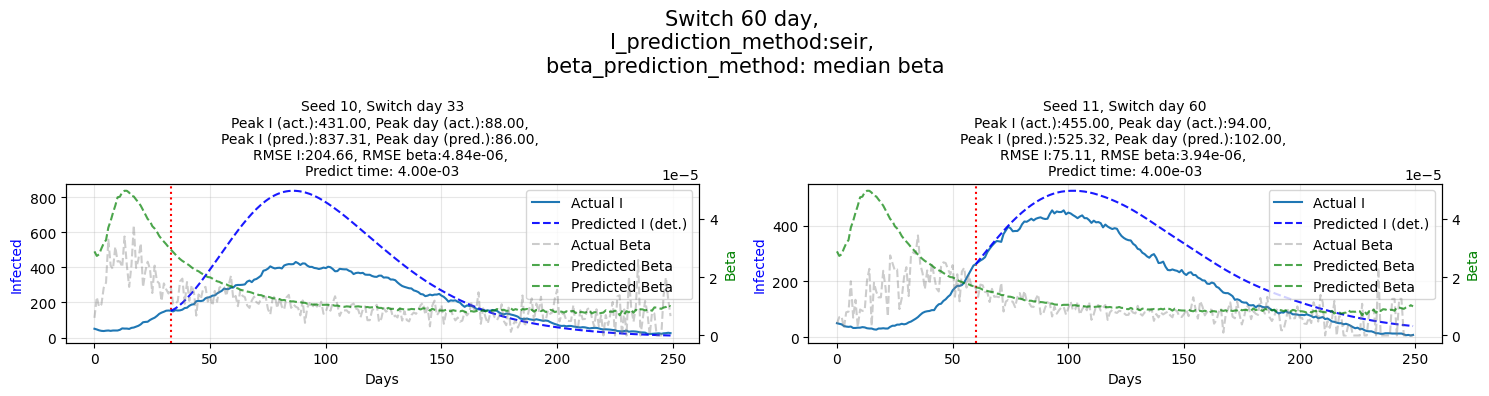

([np.float64(204.65847393826073), np.float64(75.10882203607744)],
 [np.float64(4.836943805178067e-06), np.float64(3.938269713183409e-06)],
 [[np.int64(431), np.float64(837.311893237433), np.int64(88), np.int64(86)],
  [np.int64(455), np.float64(525.3190210552002), np.int64(94), np.int64(102)]],
 [0.00400090217590332])

In [8]:
seeds = set()
seeds.update(range(int(10), int(12)))
main_f('seir', False, 0, 'median beta', 'roll_var_npeople', seeds, True, False)

# Код графического окна

In [ ]:
'''
Создание графического окна для ввода параметров
'''
def parse_seeds(seeds_input):
    ''' 
    Сортировка numbers of seeds
    '''

    # использование множества уникальных значений
    seeds = set()  
   
    parts = seeds_input.split(',') 
    for part in parts:
        if '-' in part:  # определение диапазона по тире
            start, end = part.split('-')
            seeds.update(range(int(start), int(end)))  # добавление чисел из диапазона
        else:
            seeds.add(int(part))  # добавление отдельных номеров seed
            
    return sorted(seeds)

def calculate():
    try:
        # получение значениий из полей ввода
        I_prediction_method = var_I_prediction_method.get()
        stochastic = var_stochastic.get()
        # получение количества случайных траекторий, если включена стохастичность
        count_stoch_line = int(entry_count_stoch_line.get()) if stochastic else 0  
        beta_prediction_method = var_beta_prediction_method.get()
        # получение значения дня начала
        start_day = selected_start_day.get()
        # Если выбрано 'other', преобразуем введенное значение в число
        if start_day == 'other':
            start_day = int(entry_start_day.get())
        else:
            # Используем выбранный тип
            start_day = start_day

        seed_numbers = entry_seed_numbers.get()
        # сортировка numbers of seeds
        seed_numbers = parse_seeds(seed_numbers)
        
        # вызов основной функции
        result = main_f(I_prediction_method, stochastic, count_stoch_line, 
                        beta_prediction_method, start_day, seed_numbers,
                        True, False)
        
        # вывод результата
        messagebox.showinfo("Результат", result)
    except ValueError:
        messagebox.showerror("Ошибка", "Пожалуйста, введите корректные данные.")
    except Exception as e:
        messagebox.showerror("Ошибка", f"Произошла ошибка: {str(e)}")

def show_entry_field(*args):
    if selected_start_day.get() == 'other':
        entry_start_day.pack()  # Показываем поле ввода
    else:
        entry_start_day.pack_forget()  # Скрываем поле ввода

# создание главного окна
root = tk.Tk()
root.title("Ввод параметров")

# создание переменной для выбора мат. модели
var_I_prediction_method = tk.StringVar(value="seir")  # установка значения по умолчанию
# создание выпадающего списока для выбора мат. модели
label_I_prediction_method = tk.Label(root, text="Метод предсказания Infected:")
label_I_prediction_method.pack()
I_prediction_method_options = ["seir"]
dropdown_I_prediction_method = tk.OptionMenu(root, var_I_prediction_method, 
                                             *I_prediction_method_options)
dropdown_I_prediction_method.pack()

# создание флажка для стохастичности
var_stochastic = tk.BooleanVar(value=False)
checkbox_stochastic = tk.Checkbutton(root, text="Стохастичность", 
                                     variable=var_stochastic, 
                                     command=lambda: toggle_stochastic_entry())
checkbox_stochastic.pack()

# создание метки и поля ввода для количество стохастических траекторий
label_count_stoch_line = tk.Label(root, text="Количество случайных траекторий:")
label_count_stoch_line.pack()
entry_count_stoch_line = tk.Entry(root)
entry_count_stoch_line.pack()
entry_count_stoch_line.config(state='disabled')  # изначальное отключение поле ввода
# функция для включения/выключения поля ввода в зависимости от состояния флажка
def toggle_stochastic_entry():
    if var_stochastic.get():
        entry_count_stoch_line.config(state='normal')  # включение поля ввода
    else:
        entry_count_stoch_line.config(state='disabled')  # отключение поля ввода

# создание переменной для выбора метода предсказания значений Beta
# Устанавливаем значение по умолчанию
var_beta_prediction_method = tk.StringVar(value="last value") 
# создание выпадающего список для выбора метода
label_beta_prediction_method = tk.Label(root, text="Метод предсказания Beta:")
label_beta_prediction_method.pack()
beta_prediction_method_options =  ['last_value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)'

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
dropdown_beta_prediction_method = tk.OptionMenu(root, var_beta_prediction_method, 
                                                *beta_prediction_method_options)
dropdown_beta_prediction_method.pack()

# создание метки и поля ввода типа выбора дня переключения на мат. модель
# переменная для выбора типа дня начала
selected_start_day = tk.StringVar(value="other")
selected_start_day.trace('w', show_entry_field)  # отслеживаем изменения
# создание выпадающего списка для выбора типа дня начала
label_start_day = tk.Label(root, text="Тип вычисления дня переключения на мат. модель:")
label_start_day.pack()
start_day_options = ['roll_var', 
                     'norm_var', 
                     'roll_var_seq', 
                     'roll_var_npeople', 
                     'other']
dropdown_start_day = tk.OptionMenu(root, selected_start_day, *start_day_options)
dropdown_start_day.pack()

# поле ввода для ввода дня, когда выбрано 'other'
entry_start_day = tk.Entry(root)
entry_start_day.pack()
entry_start_day.config(state='normal')  # По умолчанию включаем поле ввода

# создание метки и поля ввода для numbers of seeds
label_seed_numbers = tk.Label(root, 
                              text="Seed_numbers (через запятую или диапазон через тире):")
label_seed_numbers.pack()
entry_seed_numbers = tk.Entry(root)
entry_seed_numbers.pack()

# создание кнопки для выполнения вычисления
button_calculate = tk.Button(root, text="Вычислить", command=calculate)
button_calculate.pack() 

# запуск главного цикла приложения
root.mainloop()

# RMSE Infected и Beta

### Save RMSE Infected и Beta for all beta_prediction_method and star_day = 40, 50, 60

In [ ]:
'''
seeds = set()
seeds.update(range(int(0), int(30)))
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
days = np.array([40,50,60])
for day in days:
    # Словарь для хранения RMSE для каждого метода
    rmse_I_results = {method: [] for method in methods}
    rmse_Beta_results = {method: [] for method in methods}
    time_results = {method: [] for method in methods}
    for beta_prediction_method in methods:
        all_rmse_I, all_rmse_Beta, _ , time_res= main_f('seir', False, 0, beta_prediction_method, day, seeds,False, False)
        rmse_I_results[beta_prediction_method].extend(all_rmse_I)  # Сохраняем RMSE в словарь
        rmse_Beta_results[beta_prediction_method].extend(all_rmse_Beta)
        time_results[beta_prediction_method].extend(time_res)

    # Преобразуем словарь в DataFrame
    rmse_I_df = pd.DataFrame(rmse_I_results)
    rmse_Beta_df = pd.DataFrame(rmse_Beta_results)
    time_df = pd.DataFrame(time_results)
    # Сохраняем DataFrame в CSV файл
    rmse_I_df.to_csv(f'RMSE_Infected_and_Beta/Infected/rmse_I_results_{day}_day_start.csv', index=False)
    rmse_Beta_df.to_csv(f'RMSE_Infected_and_Beta/Beta/rmse_Beta_results_{day}_day_start.csv', index=False)
    time_df.to_csv(f'time_predict_Infected_and_Beta/time_predict_{day}_day_start.csv', index=False)
'''    

"\nseeds = set()\nseeds.update(range(int(0), int(30)))\nmethods = ['last value',\n        'rolling mean last value',\n        'expanding mean last value',\n        'biexponential decay', \n        \n        'median beta',\n        'regression (day)',\n\n        'median beta;\nshifted forecast',\n        'regression (day);\nshifted forecast',\n        'regression (day);\nincremental learning',\n        'regression (day, SEIR, previous I)',       \n        'lstm (day, E, previous I)']\ndays = np.array([40,50,60])\nfor day in days:\n    # Словарь для хранения RMSE для каждого метода\n    rmse_I_results = {method: [] for method in methods}\n    rmse_Beta_results = {method: [] for method in methods}\n    time_results = {method: [] for method in methods}\n    for beta_prediction_method in methods:\n        all_rmse_I, all_rmse_Beta, _ , time_res= main_f('seir', False, 0, beta_prediction_method, day, seeds)\n        rmse_I_results[beta_prediction_method].extend(all_rmse_I)  # Сохраняем RMSE в

### Boxplot RMSE for Infected 


all beta_prediction_method, start_day = 40, 50, 60

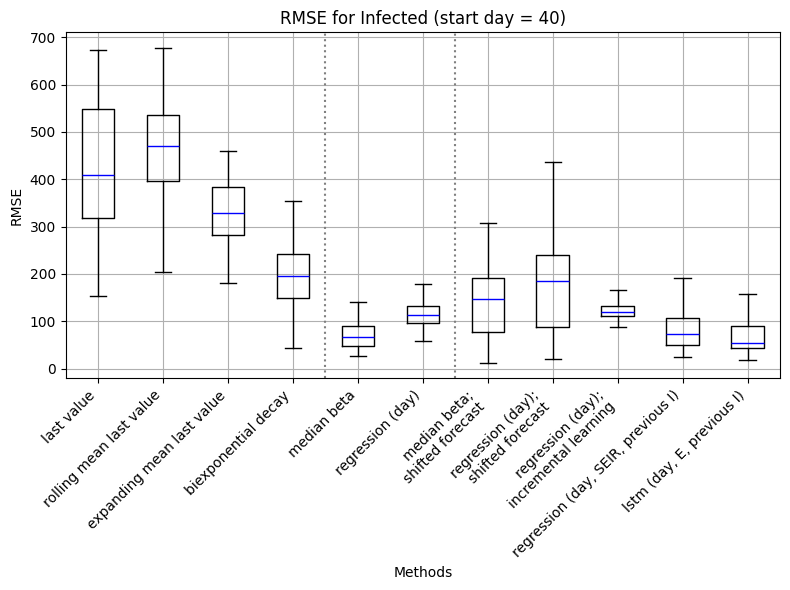

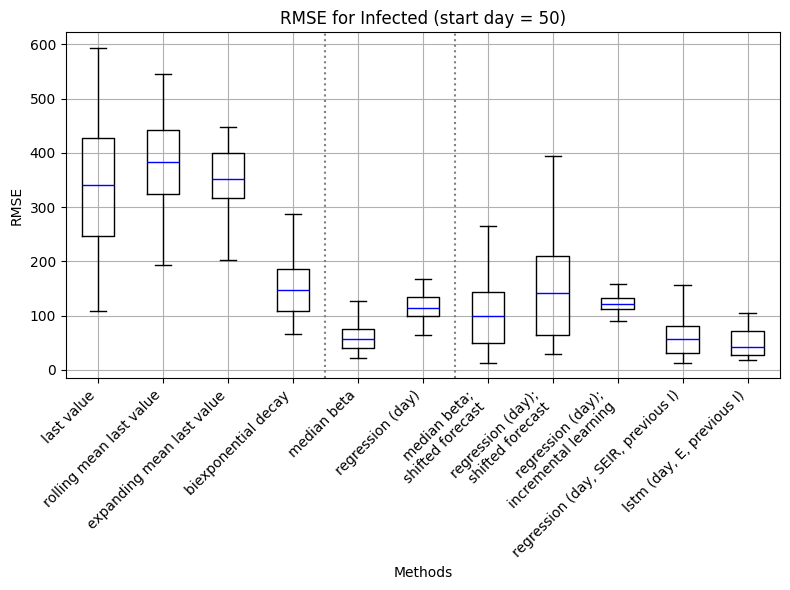

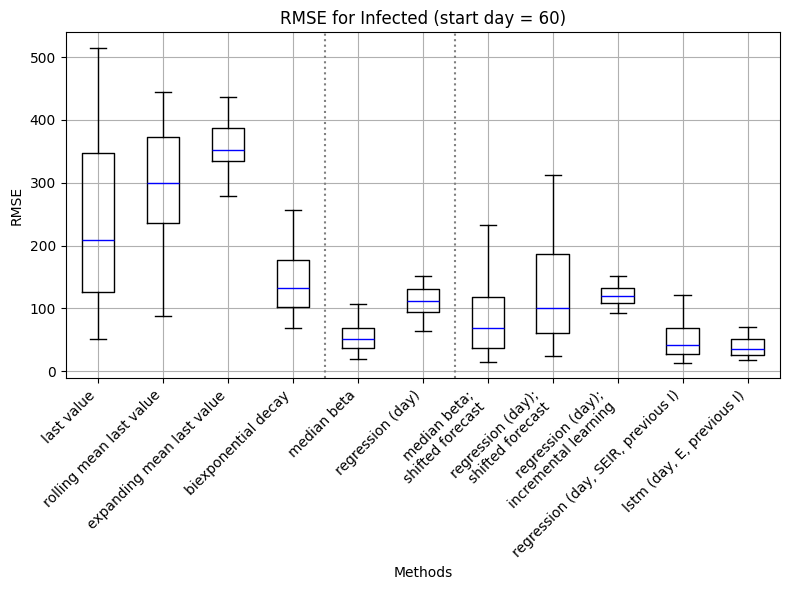

In [60]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
days = np.array([40,50,60])
for day in days:
    # Загрузка данных из CSV
    rmse_df = pd.read_csv(f'RMSE_Infected_and_Beta/Infected/rmse_I_results_{day}_day_start.csv')

    # Создание боксплота
    plt.figure(figsize=(8,6))  # Установка размера графика
    box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='blue'),widths=0.5)

    # Настройка заголовка и меток
    plt.title(f'RMSE for Infected (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')

    plt.axvline(4.5, ls=':', color='gray')
    plt.axvline(6.5, ls=':', color='gray')

    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.grid()
    plt.savefig(f'RMSE_Infected_and_Beta/Infected/rmse_I_boxplot_{day}_start.pdf', format='pdf', dpi=300, bbox_inches='tight')    
    plt.show()

3 group of beta_prediction_method, start_day = 50

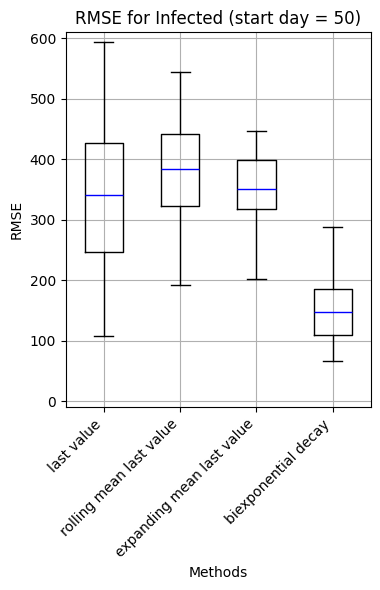

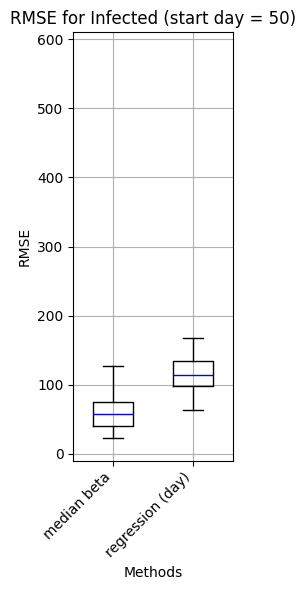

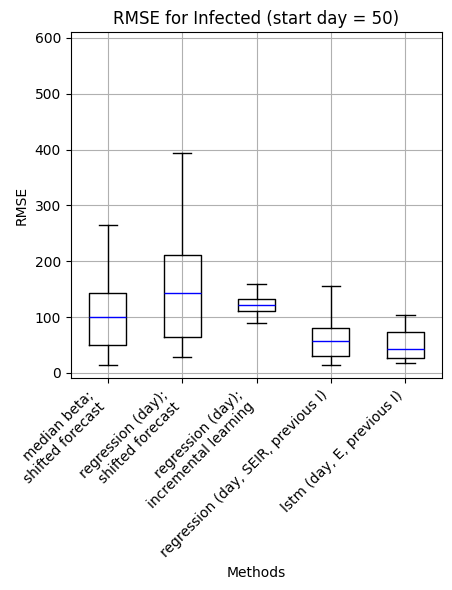

In [61]:
methods = [['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay'], 
        
        ['median beta',
        'regression (day)'],

        ['median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']]
day = 50
# Загрузка данных из CSV
rmse_df = pd.read_csv(f'RMSE_Infected_and_Beta/Infected/rmse_I_results_{day}_day_start.csv')
for i in range(len(methods)):
    # Создание боксплота
    plt.figure(figsize=(8*len(methods[i])/11+1,6))  # Установка размера графика
    box = plt.boxplot(rmse_df[methods[i]], showfliers=False, medianprops=dict(color='blue'), widths=0.5)

    # Настройка заголовка и меток
    plt.title(f'RMSE for Infected (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=45, ha='right')


    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.grid()
    plt.ylim(-10, 610)
    plt.savefig(f'RMSE_Infected_and_Beta/Infected/rmse_I_boxplot_{day}_day_start_group_{i}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

### Boxplot RMSE for Beta

all beta_prediction_method, start_day = 40, 50, 60

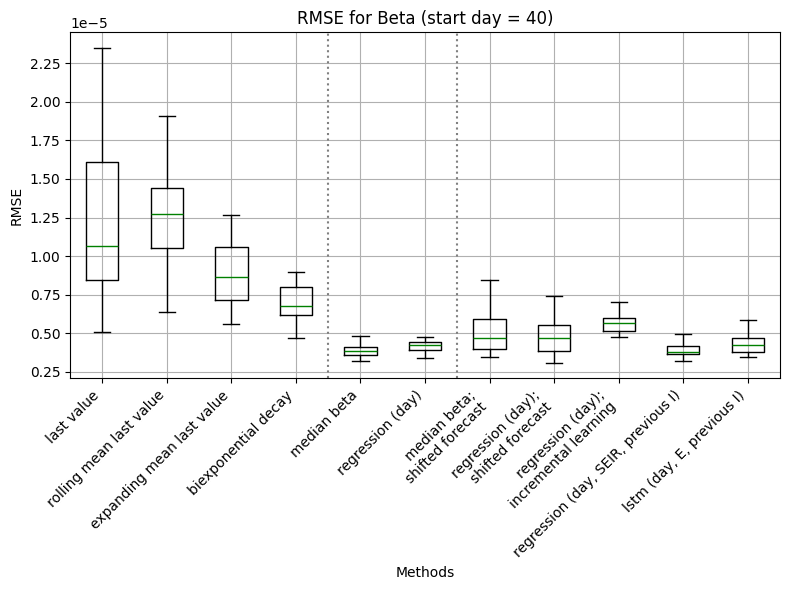

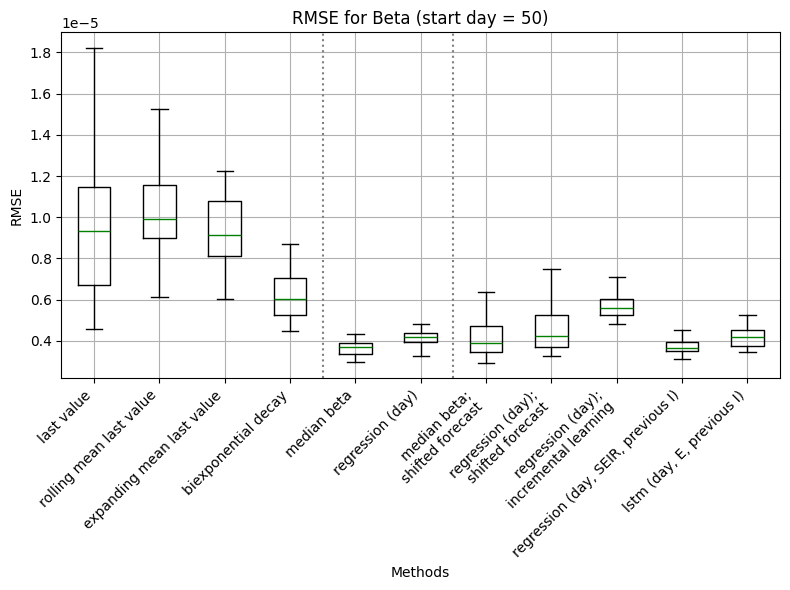

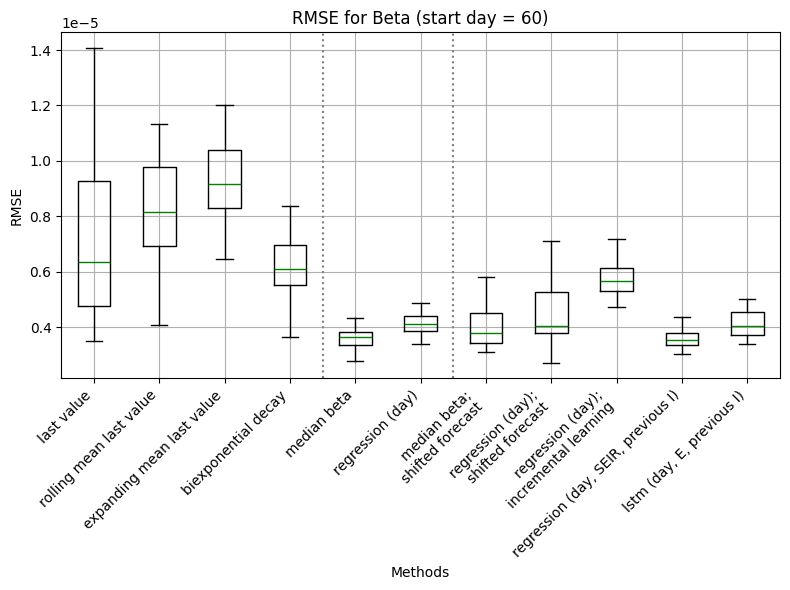

In [62]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
days = np.array([40,50,60])
for day in days:
    # Загрузка данных из CSV
    rmse_df = pd.read_csv(f'RMSE_Infected_and_Beta/Beta/rmse_Beta_results_{day}_day_start.csv')

    # Создание боксплота
    plt.figure(figsize=(8,6))  # Установка размера графика
    box = plt.boxplot(rmse_df, showfliers=False, medianprops=dict(color='green'),widths=0.5)

    # Настройка заголовка и меток
    plt.title(f'RMSE for Beta (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, rmse_df.shape[1]+1), 
            labels=methods, rotation=45, ha='right')

    plt.axvline(4.5, ls=':', color='gray')
    plt.axvline(6.5, ls=':', color='gray')
 
    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.grid()
    plt.savefig(f'RMSE_Infected_and_Beta/Beta/rmse_Beta_boxplot_{day}_start.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()


3 group of beta_prediction_method, start_day = 50

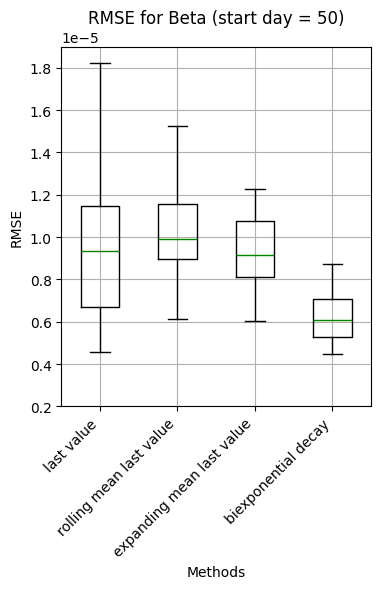

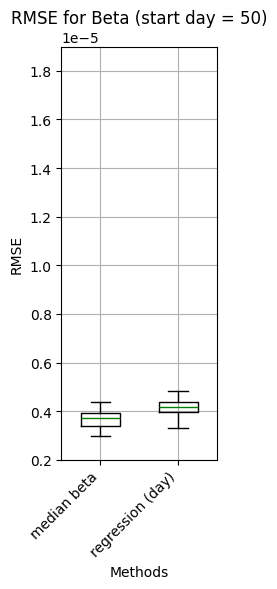

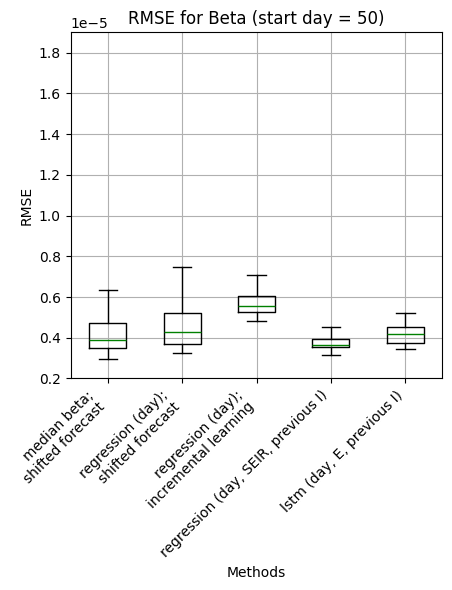

In [63]:
methods = [['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay'], 
        
        ['median beta',
        'regression (day)'],

        ['median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']]
day = 50
# Загрузка данных из CSV
rmse_df = pd.read_csv(f'RMSE_Infected_and_Beta/Beta/rmse_Beta_results_{day}_day_start.csv')
for i in range(len(methods)):
    # Создание боксплота
    plt.figure(figsize=(8*len(methods[i])/11+1,6))  # Установка размера графика
    box = plt.boxplot(rmse_df[methods[i]], showfliers=False, medianprops=dict(color='green'), widths=0.5)

    # Настройка заголовка и меток
    plt.title(f'RMSE for Beta (start day = {day})')
    plt.xlabel('Methods')
    plt.ylabel('RMSE')

    # Поворот меток по оси X для лучшей читаемости
    plt.xticks(ticks=np.arange(1, len(methods[i])+1), 
            labels=methods[i], rotation=45, ha='right')
    

    # Показать график
    plt.tight_layout()  # Автоматическая настройка отступов
    plt.grid()
    plt.ylim(0.2 * 1e-5, 1.9 * 1e-5)
    plt.savefig(f'RMSE_Infected_and_Beta/Beta/rmse_Beta_boxplot_{day}_day_start_group_{i}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Peak Infected and day

### Save peak Infected and day for all beta_prediction_method and star_day = 50

In [ ]:
'''
seeds = set()
seeds.update(range(int(0), int(30)))
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I)']

for beta_prediction_method,new_labels in zip(methods, new_labels):
    _,_, peak_metrics_results , _ = main_f('seir', False, 0, beta_prediction_method, 50, seeds, False, False)
    peak_metrics = pd.DataFrame(peak_metrics_results, columns = ['actual_peak_I', 'predicted_peak_I','actual_peak_day','predicted_peak_day'])
    peak_metrics.to_csv(f'peak_Infected_and_day/{new_labels}_peak_results_50_start_day.csv', index=False)
'''

### Show plots

In [11]:
methods = ['last value',
        'rolling mean last value',
        'expanding mean last value',
        'biexponential decay', 
        
        'median beta',
        'regression (day)',

        'median beta;\nshifted forecast',
        'regression (day);\nshifted forecast',
        'regression (day);\nincremental learning',
        'regression (day, SEIR, previous I)',       
        'lstm (day, E, previous I)']
new_labels = ['last_value',
        'rolling_mean_last_value',
        'expanding_mean_last_value',
        'biexponential_decay', 
        
        'median_beta',
        'regression_day',

        'median_beta_shifted_forecast',
        'regression_day_shifted_forecast',
        'regression_day_incremental_learning',
        'regression_day_SEIR_previous_I',       
        'lstm_day_E_previous_I)']

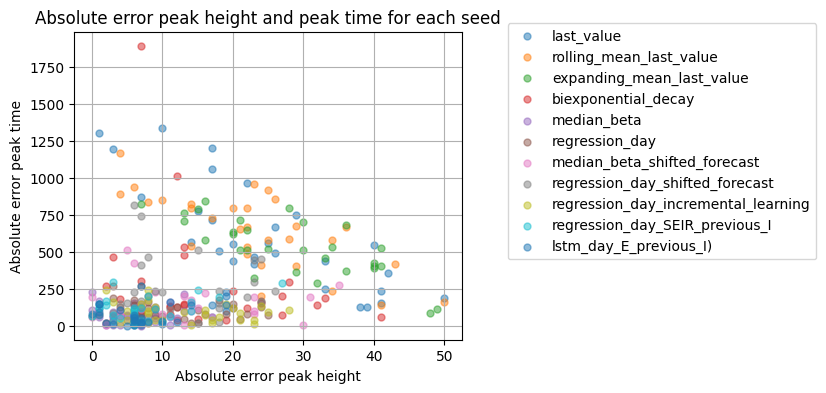

In [12]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
for name in new_labels:
    p_df = pd.read_csv(f'peak_Infected_and_day/{name}_peak_results_50_start_day.csv')
    
    ax.scatter(abs(p_df['actual_peak_day']-p_df['predicted_peak_day']),
               abs(p_df['actual_peak_I']-p_df['predicted_peak_I']),
               marker='.', s=100,  alpha=0.5, label=name)
    
ax.set_title('Absolute error peak height and peak time for each seed')    
ax.set_xlabel('Absolute error peak height')
ax.set_ylabel('Absolute error peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.grid()
plt.savefig(f'peak_Infected_and_day/absolute_error_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')

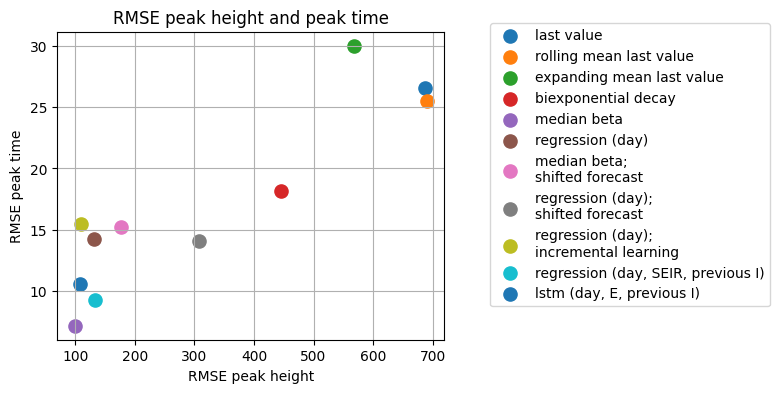

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))
rmse_ph = []
rmse_pt = []
for name in new_labels:
    p_df = pd.read_csv(f'peak_Infected_and_day/{name}_peak_results_50_start_day.csv')
    rmse_ph.append(rmse(p_df.iloc[:]['actual_peak_I'], p_df.iloc[:]['predicted_peak_I']))
    rmse_pt.append(rmse(p_df.iloc[:]['actual_peak_day'], p_df.iloc[:]['predicted_peak_day']))
    
for i, name in enumerate(methods):   
    ax.scatter(rmse_ph[i], rmse_pt[i], marker='o', s=90, label=name)
    
ax.set_title('RMSE peak height and peak time')    
ax.set_xlabel('RMSE peak height')
ax.set_ylabel('RMSE peak time')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.grid()

plt.savefig(f'peak_Infected_and_day/rmse_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')


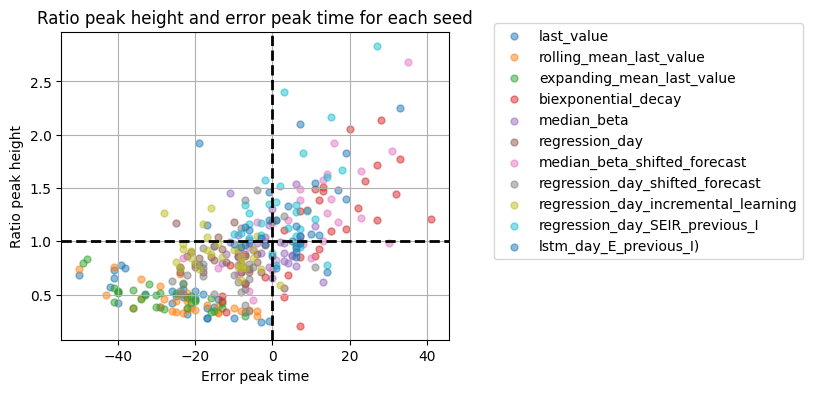

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5, 4))

for name in new_labels:
    p_df = pd.read_csv(f'peak_Infected_and_day/{name}_peak_results_50_start_day.csv')
    ph = []
    pt = []
    ph.append([p_df.iloc[:]['actual_peak_I']/p_df.iloc[:]['predicted_peak_I']])
    pt.append([p_df.iloc[:]['actual_peak_day']-p_df.iloc[:]['predicted_peak_day']])
    
    ax.scatter(pt,ph, marker='.', s=100,  alpha=0.5, label=name)
ax.set_title('Ratio peak height and error peak time for each seed')    
ax.set_xlabel('Error peak time')
ax.set_ylabel('Ratio peak height')
ax.legend(bbox_to_anchor=(1.1, 1.05))

ax.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Difference of peak time=0')
ax.axhline(y=1, color='black', linestyle='--', linewidth=2, label='Ratio of peak height=1')
ax.grid()

plt.savefig(f'peak_Infected_and_day/ratio_and_error_peaks.pdf', format='pdf', dpi=300, bbox_inches='tight')
